# 环境配置

## 导入包、配置路径

In [92]:
import pandas as pd
import numpy as np
import json
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib
matplotlib.style.use('ggplot')
pd.set_option('max_colwidth',50)
import torch

from loguru import logger

In [93]:
fname = 'data/processed/train.jsonl'

## 数据预处理

### 读取

In [94]:
d = list(json.loads(x) for x in open(fname, 'r', encoding='utf-8').read().strip().split('\n'))
df = pd.DataFrame(d)

### 删除共现标签

#### 寻找共现标签

In [95]:
df

,id,text,label
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,[label_878402]
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去...,[label_878402]
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现...,[label_878402]
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,[label_878402]
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,[label_878402]
...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主...,[label_82331]
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 202206...,[label_82331]
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,[label_82331]
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,[label_82331]


In [96]:
# 所有label的set
label_set = set()
for e in df['label']:
    for e_label in e:
        label_set.add(e_label)

# 每一个label的出现的布尔值
s = 77314
label2bin = {}
for e in tqdm(label_set):
    position_v = np.zeros(s, dtype=int)
    for i, row in enumerate(df['label']):
        if e in row:
            position_v[i] = 1
    label2bin[e] = int(''.join(list(str(x) for x in position_v.tolist())), 2)


100%|██████████| 1399/1399 [00:35<00:00, 39.86it/s]


In [7]:
label_list = sorted(list((v, k) for k, v in label2bin.items()))
fingerprint2label = {}
for k, v in label2bin.items():
    if v not in fingerprint2label:
        fingerprint2label[v] = [k]
    else:
        fingerprint2label[v].append(k)

In [8]:
same_groups = []
for v in fingerprint2label.values():
    if len(v) >= 2:
        same_groups.append(v)
same_groups

[['label_1511186', 'label_200117'],
 ['label_1051923', 'label_1093165'],
 ['label_732973', 'label_324867'],
 ['label_377534', 'label_379674'],
 ['label_1525546', 'label_1112826'],
 ['label_1028847', 'label_414139'],
 ['label_1287165', 'label_654154'],
 ['label_1370355', 'label_1053744', 'label_425409'],
 ['label_823607', 'label_522067'],
 ['label_1267614', 'label_778062', 'label_797451'],
 ['label_192345',
  'label_1452970',
  'label_856086',
  'label_316577',
  'label_1159087',
  'label_319988',
  'label_1199707'],
 ['label_1172987', 'label_1092264'],
 ['label_164327', 'label_428832', 'label_1115848'],
 ['label_469605', 'label_1035661'],
 ['label_567947', 'label_560891'],
 ['label_892467', 'label_843277', 'label_330262', 'label_868542'],
 ['label_1102183', 'label_1432912'],
 ['label_45842', 'label_674088', 'label_309207', 'label_317424'],
 ['label_1101955', 'label_251474'],
 ['label_1276336', 'label_909265'],
 ['label_1146073', 'label_517046', 'label_1517472'],
 ['label_428087', 'labe

In [9]:
json.dump(same_groups, open('temp_data/equivalent_labels.json', 'w', encoding='utf-8'))

In [98]:
same_groups = json.load(open('temp_data/equivalent_labels.json', 'r', encoding='utf-8'))

In [99]:
label2equivalent = {}
for e in same_groups:
    label2equivalent[e[0]] = e[1:]

In [12]:
json.dump(label2equivalent, open('temp_data/label2equivalent.json', 'w', encoding='utf-8'))

#### 删除一致标签

##### 需要删除的label
因为共现label的出现是完全一致的，因此只需要保留一个即可

In [100]:
delete_set = set()
for e in same_groups:
    for d in e[1:]:
        delete_set.add(d)

##### 用来删除list中共现label的函数

In [101]:
def update_list(l):
    new_list = []
    for e in l:
        if e not in delete_set:
            new_list.append(e)
    return new_list

In [102]:
filtered_df = df.copy()
filtered_df['label'] = filtered_df['label'].apply(update_list)

In [103]:
filtered_df

,id,text,label
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,[label_878402]
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去...,[label_878402]
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现...,[label_878402]
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,[label_878402]
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,[label_878402]
...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主...,[label_82331]
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 202206...,[label_82331]
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,[label_82331]
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,[label_82331]


# 数据分析

In [3]:
d = list(json.loads(x) for x in open(fname, 'r', encoding='utf-8').read().strip().split('\n'))
odf = pd.DataFrame(d)
odf

,id,text,label
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,[label_878402]
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去...,[label_878402]
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现...,[label_878402]
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,[label_878402]
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,[label_878402]
...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主...,[label_82331]
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 202206...,[label_82331]
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,[label_82331]
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,[label_82331]


### 按标签explode后，对标签进行分析

In [150]:
df = df.explode('label')
df

,id,text,label,cnt
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,label_878402,1
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去玩了[航母],label_878402,1
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现象还是需要很多依据证明的,label_878402,1
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,label_878402,1
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,label_878402,1
...,...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看！ ​​​,label_82331,1
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” ​​​,label_82331,1
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,label_82331,1
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,label_82331,1


In [151]:
df['label'].value_counts().describe()

count     1023.000000
mean        96.219941
std        523.856148
min          1.000000
25%         11.000000
50%         19.000000
75%         44.500000
max      10235.000000
Name: label, dtype: float64

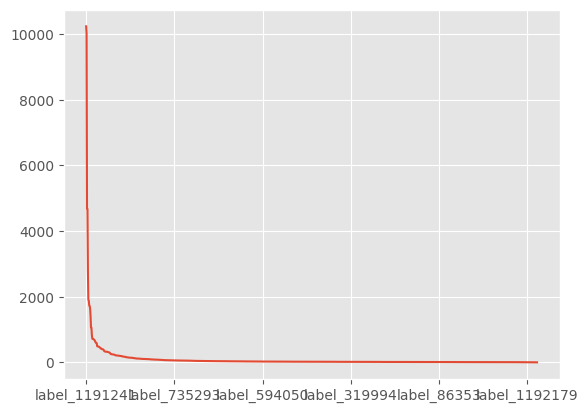

In [152]:
df['label'].value_counts().plot()
plt.show()

In [65]:
((df['label'].value_counts() <5) * df['label'].value_counts()).sum()

101

In [77]:
(df['label'].value_counts() == 18).sum()

67

In [153]:
df_label_counts = df['label'].value_counts()
df_label_counts[:20]

label_1191241    10235
label_1008181    10023
label_1281707     4680
label_472394      4671
label_742793      2783
label_1411524     1906
label_1265038     1881
label_896157      1730
label_1064693     1719
label_467023      1641
label_1474127     1421
label_1227838     1066
label_19479       1060
label_287908       828
label_753343       719
label_1056127      716
label_529001       711
label_512340       704
label_1438711      695
label_313744       675
Name: label, dtype: int64

In [122]:
id_label1 = df[df['label'] == 'label_1515062']['id']
id_label2 = df[df['label'] == 'label_472394']['id']
len(set(id_label1).intersection(set(id_label2)))

4671

### 对标签的相互关系进行分析

In [4]:
odf['cnt'] = odf.apply(lambda x: len(x['label']), axis=1)
odf

,id,text,label,cnt
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,[label_878402],1
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去...,[label_878402],1
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现...,[label_878402],1
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,[label_878402],1
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,[label_878402],1
...,...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主...,[label_82331],1
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 202206...,[label_82331],1
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,[label_82331],1
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,[label_82331],1


#### 获取基础统计信息

In [126]:
odf['cnt'].describe()

count    77314.000000
mean         1.517513
std          0.716919
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          8.000000
Name: cnt, dtype: float64

In [99]:
odf['cnt'].value_counts()

1    45329
2    24989
3     6525
4      247
8       83
5       72
6       52
7       17
Name: cnt, dtype: int64

In [106]:
odf['label_1191241' in odf['label']]

KeyError: False

In [8]:
len(same_groups)

296

In [13]:
df = filtered_df

# 关键词方案

是否存在一些句子，其中包含的关键词与标签有着极强的联系？

例如对于TF家族，“超话”、“TF家族”这些词几乎是必出现的。对于某些频数没那么高的数据，也有可能存在这种情况。

## 分析关键词

##### 寻找单个关键词的函数

In [14]:
# 验证一个关键词在所有句子中出现的次数
def validate_keyword(word, sentences):
    sentence_cnt = len(sentences)
    appear_cnt = 0
    for e in sentences:
        if word in e:
            appear_cnt += 1
    return appear_cnt, sentence_cnt, appear_cnt / sentence_cnt if sentence_cnt != 0 else 0



In [15]:
validate_keyword('左航', df[df['label'] == 'label_1191241']['text'])

(0, 0, 0)

### 观察频数最高的一批标签

In [16]:
top_k = 25

In [17]:
df_expand = filtered_df.copy().explode('label')
df_label_cnt = df_expand['label'].value_counts()

In [18]:
observing_rank = 0
observing_label = df_label_cnt.index[observing_rank]
df_expand[df_expand['label'] == observing_label]

,id,text,label,cnt
1286,1286,左航ZH🎀 🎀 “喜欢海 喜欢花 喜欢日出和日落 浪漫的年纪别活的太无趣” @TF家族-左航,label_1191241,2
1287,1287,左航ZH超话 💕 💖 @TF家族-左航 左航丨“秋天的暖风也万物枯荣皆为你眼 我目眩神驰 ...,label_1191241,2
1288,1288,左航ZH超话 你就像夹心饼干间的那一点甜，是疲乏生活中的些许慰藉。 @TF家族-左航 ​,label_1191241,2
1289,1289,左航ZH🎀 🎀 Love will only grow stronger in the da...,label_1191241,2
1290,1290,左航ZH超话🎀 🎀 🌙｜𝐼 𝓀𝓃𝑜𝓌 𝒽𝑒 𝒾𝓈 𝒶𝓈 𝒻𝒶𝓇 𝒶𝓌𝒶𝓎 𝒶𝓈 𝓉𝒽𝑒 𝓂...,label_1191241,2
...,...,...,...,...
30967,30967,左航ZH💞 💙 左航永远是我的首选，也永远是我的偏爱 @TF家族-左航,label_1191241,2
30968,30968,左航ZH超话 @TF家族-左航 我想，能使生活美满的，只有爱情 ——《红牡丹》林语堂 ​​​,label_1191241,2
30969,30969,左航ZH超话💙 💙 谈什么诗和远方，我只想和你儿女情长 @TF家族-左航 ​,label_1191241,2
30970,30970,左航ZH超话12 “爱意在厌阳高照中灿烂 思念在星火斑斓的中沉沦” @TF家族-左航 ​​​,label_1191241,2


In [19]:
observing_label

'label_1191241'

## 关键词抽取

先尝试每个句子一个关键词的方案，然后再看多个关键词的方案。

#### 分词

##### 导入分词相关工具包

In [14]:
import jieba

In [15]:
df_splitted = filtered_df.copy()
df_splitted['splitted'] = df_splitted['text'].apply(lambda x: list(jieba.cut(x)))

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.882 seconds.
Prefix dict has been built successfully.


In [16]:
df_splitted

,id,text,label,splitted
0,0,原来是这样啊，又是一个新的道理，简直让我长知识了，七星连珠是很难得的一种现象，这个解析也太到位了,[label_878402],"[原来, 是, 这样, 啊, ，, 又, 是, 一个, 新, 的, 道理, ，, 简直, 让..."
1,1,老师好厉害，咱就是说，老师，能不能，就是，研究一下能不能穿越🙏 代入感很强，我已经想穿越去...,[label_878402],"[ , 老师, 好, 厉害, ，, 咱, 就是说, ，, 老师, ，, 能, 不能, ，, ..."
2,2,这个七星连珠的现象居然真的存在，我只在小说上面看过，太神奇了吧，至于其他的我也不太懂，科学现...,[label_878402],"[这个, 七星, 连珠, 的, 现象, 居然, 真的, 存在, ，, 我, 只, 在, 小说..."
3,3,应该听过张老师讲，这一个的人都会觉得特别的清晰吧，而且也明白七星连珠不会引发危害。 ​,[label_878402],"[应该, 听过, 张老师, 讲, ，, 这, 一个, 的, 人, 都, 会, 觉得, 特别,..."
4,4,七星连珠这不是应该是天文知识吗，怎么物理也可以，学霸的世界我果然不懂啊,[label_878402],"[七星, 连珠, 这, 不是, 应该, 是, 天文, 知识, 吗, ，, 怎么, 物理, 也..."
...,...,...,...,...
77309,77309,甘肃兰州2022年文化和自然遗产日主场城市活动亮点抢先看甘肃兰州2022年文化和自然遗产日主...,[label_82331],"[甘肃兰州, 2022, 年, 文化, 和, 自然遗产, 日, 主场, 城市, 活动, 亮点..."
77310,77310,《焦点访谈》 20220611 让文物活起来 国宝自己会“说话” 《焦点访谈》 202206...,[label_82331],"[《, 焦点访谈, 》, , 20220611, , 让, 文物, 活, 起来, , ..."
77311,77311,甘肃加大农机装备力量投入“三夏”生产网页链接,[label_82331],"[甘肃, 加大, 农机, 装备, 力量, 投入, “, 三夏, ”, 生产, 网页, 链接]"
77312,77312,小范书记们，村民都在等荐书 网页链接 ​​​,[label_82331],"[小范, 书记, 们, ，, 村民, 都, 在, 等, 荐, 书, , 网页, 链接, ..."


In [22]:
vocabulary = set()
for e in tqdm(df_splitted['splitted']):
    vocabulary = vocabulary.union(set(e))
vocabulary = sorted(list(vocabulary))
vocabulary_idx = {x: i for i, x in enumerate(vocabulary)}
len(vocabulary)

100%|██████████| 77314/77314 [02:12<00:00, 584.25it/s] 


87875

In [14]:
json.dump(vocabulary, open('temp_data/vocabulary.json', 'w', encoding='utf-8'))
json.dump(vocabulary_idx, open('temp_data/vocabulary_idx.json', 'w', encoding='utf-8'))

In [73]:
vocabulary = json.load(open('temp_data/vocabulary.json', 'r', encoding='utf-8'))
vocabulary_idx = json.load(open('temp_data/vocabulary_idx.json', 'r', encoding='utf-8'))

In [15]:
vocabulary = json.load(open('temp_data/vocabulary.json', 'r', encoding='utf-8'))
vocabulary_idx = json.load(open('temp_data/vocabulary_idx.json', 'r', encoding='utf-8'))

In [17]:
# shape=(vocab, sentence cnt)，词语在句子中的出现矩阵
vocab_appear = np.zeros((len(vocabulary), df_splitted.shape[0]), dtype=bool)
for i, row in tqdm(enumerate(df_splitted['splitted'])):
    for w in row:
        w_idx = vocabulary_idx[w]
        vocab_appear[w_idx][i] = True


77314it [00:02, 27868.50it/s]


In [17]:
df_splitted.shape[0]

77314

In [24]:
label_vocabulary = set()
for e in tqdm(df_splitted['label']):
    label_vocabulary = label_vocabulary.union(set(e))
label_vocabulary = sorted(list(label_vocabulary))
label_vocabulary_idx = {x: i for i, x in enumerate(label_vocabulary)}
len(label_vocabulary)

100%|██████████| 77314/77314 [00:00<00:00, 198593.54it/s]


1023

In [25]:
json.dump(label_vocabulary, open('temp_data/label_vocabulary.json', 'w', encoding='utf-8'))
json.dump(label_vocabulary_idx, open('temp_data/label_vocabulary_idx.json', 'w', encoding='utf-8'))

In [74]:
label_vocabulary = json.load(open('temp_data/label_vocabulary.json', 'r', encoding='utf-8'))
label_vocabulary_idx = json.load(open('temp_data/label_vocabulary_idx.json', 'r', encoding='utf-8'))

In [18]:
# shape=(label_vocab, sentence cnt) 标签在句子中的出现矩阵
label_appear = np.zeros((len(label_vocabulary), df_splitted.shape[0]), dtype=bool)
for i, row in tqdm(enumerate(df_splitted['label'])):
    for l in row:
        l_idx = label_vocabulary_idx[l]
        label_appear[l_idx][i] = True

77314it [00:00, 709653.77it/s]


In [ ]:
# 计算词语对标签的出现
# (vocab, sent cnt) x (sent cnt, label_vocab)
word_in_label = np.matmul(vocab_appear, label_appear.T)

In [22]:
def frag_matmul(a, b, max_dim=100, verbose=False, use_cuda=False):
    # a = (a1, m), b = (m, b2)
    # 将a1和a2化为多个长为100的block
    a_rows, b_columns = [], []
    
    if verbose:
        logger.info('正在碎片化')
    dim_a, dim_b = a.shape[0], b.shape[1]
    a_frag_cnt = (dim_a + max_dim - 1) // max_dim
    b_frag_cnt = (dim_b + max_dim - 1) // max_dim
    for ia in range(a_frag_cnt):
        a_rows.append(a[ia * max_dim: min((ia + 1) * max_dim, a.shape[0])])
    for ib in range(b_frag_cnt):
        b_columns.append(b[:, ib * max_dim: min((ib + 1) * max_dim, b.shape[1])])
    
    results = []
    if verbose:
        logger.info('正在将碎片进行矩阵乘法')
    if use_cuda:
        for i_r in tqdm(range(a_frag_cnt)):
            results.append([])
            for i_c in range(b_frag_cnt):
                cur_a_row = torch.tensor(a_rows[i_r]).to(torch.float).to('cuda')
                cur_b_column = torch.tensor(b_columns[i_c]).to(torch.float).to('cuda')
                res = torch.matmul(cur_a_row, cur_b_column)
                results[-1].append(np.array(res.cpu(), dtype=int))
    else:
        for i_r in tqdm(range(a_frag_cnt)):
            results.append([])
            for i_c in range(b_frag_cnt):
                results[-1].append(np.matmul(a_rows[i_r], b_columns[i_c]))
    
    
    if verbose: logger.info('正在合并碎片')
    np_rows = []
    for erow in tqdm(results):
        np_rows.append(np.concatenate(erow, axis=1))
    np_result = np.concatenate(np_rows)
    return np_result
    

In [19]:
vocab_appear.shape, label_appear.T.shape

((87875, 77314), (77314, 1023))

In [24]:
vocab_appear[0:1].shape

(1, 77314)

In [23]:
word_in_label = frag_matmul(vocab_appear, label_appear.T, max_dim=30, verbose=True, use_cuda=True)

2022-12-05 10:15:48.382 | INFO     | __main__:frag_matmul:7 - 正在碎片化
2022-12-05 10:15:48.390 | INFO     | __main__:frag_matmul:18 - 正在将碎片进行矩阵乘法
100%|██████████| 2930/2930 [07:47<00:00,  6.27it/s]
2022-12-05 10:23:35.865 | INFO     | __main__:frag_matmul:34 - 正在合并碎片
100%|██████████| 2930/2930 [00:00<00:00, 33889.02it/s]


In [24]:
word_not_in_label = frag_matmul(vocab_appear, ~label_appear.T, max_dim=30, verbose=True, use_cuda=True)

2022-12-05 10:23:36.139 | INFO     | __main__:frag_matmul:7 - 正在碎片化
2022-12-05 10:23:36.143 | INFO     | __main__:frag_matmul:18 - 正在将碎片进行矩阵乘法
100%|██████████| 2930/2930 [07:55<00:00,  6.16it/s]
2022-12-05 10:31:31.608 | INFO     | __main__:frag_matmul:34 - 正在合并碎片
100%|██████████| 2930/2930 [00:00<00:00, 35143.95it/s]


In [26]:
np.save('temp_data/word_in_label', word_in_label)
np.save('temp_data/word_not_in_label', word_not_in_label)

In [46]:
word_in_label = np.load('temp_data/word_in_label.npy')
word_not_in_label = np.load('temp_data/word_not_in_label.npy')

In [32]:
word_in_label.shape

(87875, 1023)

### 计算TF·IDF

In [24]:
def cal_tfidf(wi):
    tf = wi / wi.sum(axis=0, keepdims=True)  # (vocab, label)
    idf = np.log10(wi.shape[1] / 0.1 + (wi < 1).sum(axis=1, keepdims=True))  # (vocab)
    tfidf = tf / idf
    return tfidf

In [25]:
tfidf = cal_tfidf(word_in_label)

In [39]:
word_in_label.sum(axis=0, keepdims=True)

array([[ 444, 1296, 7990, ..., 5988,  561,  993]])

In [29]:
tf = word_in_label / word_in_label.sum(axis=0, keepdims=True)

In [32]:
tf

array([[0.02477477, 0.02777778, 0.04005006, ..., 0.0497662 , 0.03565062,
        0.03423968],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.000501  , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [33]:
idf = np.log10(word_in_label.shape[1] / 0.1 + (word_in_label < 1).sum(axis=1, keepdims=True))

4.00987563371216

### 计算出现几率

In [68]:
word_importance = word_in_label / (word_not_in_label + 0.9)

In [69]:
threshold = 100

In [82]:
pos = np.where(word_importance > threshold)
keywords = []
for x, y in zip(pos[0], pos[1]):
    v = word_importance[x][y]
    word = vocabulary[x]
    label_ = label_vocabulary[y]
    keywords.append({
        'importance': v,
        'word': word,
        'label': label_
    })
keywords = pd.DataFrame(keywords)
keywords = keywords.sort_values(by='importance')

In [87]:
keywords.tail(30)

,importance,word,label
125,346.666667,铉,label_1253103
90,348.421053,日产,label_1470555
33,353.333333,hhj,label_1253103
110,367.777778,红酒,label_477040
109,367.777778,红酒,label_1305232
132,407.894737,🐆,label_1008181
3,413.333333,Anpanman,label_477040
2,413.333333,Anpanman,label_1305232
140,433.793103,🪐,label_1008181
141,433.793103,🪐,label_1204775


### 利用规则选取

In [116]:
labels = filtered_df.copy().explode('label')
total = labels.shape[0]
label_cnt = labels.value_counts('label').sort_values().to_numpy()

In [117]:
len(label_cnt)

1023

In [123]:
# word_in_label (vocab size, label cnt)
pos_flag = (word_in_label / np.expand_dims(label_cnt, 0))
neg_flag = (word_not_in_label / (total - np.expand_dims(label_cnt, 0)))

In [136]:
word_available = (pos_flag > 0.999) & (neg_flag < 0.00005)

In [138]:
word_available.sum()

9874

In [139]:
def extract_keywords(ma):
    pos = np.where(ma)
    kwords = []
    for x, y in zip(pos[0], pos[1]):
        v = ma[x][y]
        word = vocabulary[x]
        label_ = label_vocabulary[y]
        kwords.append({
            'word': word,
            'label': label_
        })
    kwords = pd.DataFrame(kwords)
    return kwords

In [140]:
akwords = extract_keywords(word_available)

In [141]:
akwords

,word,label
0,-----,label_1008181
1,-------,label_1008181
2,--------,label_1008181
3,---------,label_1008181
4,----------,label_1008181
...,...,...
9869,🪂,label_1003895
9870,🪐,label_1008181
9871,🪐,label_1204775
9872,🫐,label_1008181


## 利用关键词进行分类

In [88]:
class KeywordClassifier:
    def __init__(self, kw2cls: dict):
        """
        :param kw2cls: 一个关键词对应一个类别 word -> class
            分类时，会遍历该dict，并且使用第一个匹配到的结果
        """
        self.keywd2class = kw2cls
    
    def predict(self, sentence: str):
        for k, v in self.keywd2class.items():
            if k in sentence:
                return v
        return None